# This is a first tutorial of using gRPC for the automation of HyperLabs Piranha Platform.

### We first import all the Required Python Packages such as 'gRPC' and 'logging' as well as the gRPC "proto" files. The proto files must reside in the same directory as the jupyter notebook. An introduction to gRPC can be found here: https://grpc.io/docs/what-is-grpc/introduction/

In [5]:
import grpc
from generated.nitrogen_public_pb2_grpc import NitrogenStub
import generated.nitrogen_public_pb2 as nitrogen_public_pb2
from generated.radium_public_pb2_grpc import RadiumStub
import generated.radium_public_pb2 as radium_public_pb2
from typing import Iterator
import numpy as np
import logging
import matplotlib.pyplot as plt
import time
import threading
import queue
import sys
from IPython.display import clear_output

# Entry.
logger = logging.getLogger("app")
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s', handlers=[logging.StreamHandler()])
host_addr = "hl-piranha-demo.local"

### As a first example we request the software version running on the Piranha platform using the Nitrogen service which runs on port `50051`.

In [6]:
nitrogen_stub = NitrogenStub(grpc.insecure_channel(host_addr + ":50051"))
try:
    nitrogen_stub.IsReady(nitrogen_public_pb2.IsReadyRequest(), timeout=5)
    version = nitrogen_stub.GetVersionId(nitrogen_public_pb2.GetVersionIdRequest())
    version_parts = version.id.split('.')
    version_dict = {
        "major": version_parts[0] if len(version_parts) > 0 else "",
        "minor": version_parts[1] if len(version_parts) > 1 else "",
        "patch": version_parts[2] if len(version_parts) > 2 else "",
        "reserved": version_parts[3] if len(version_parts) > 3 else ""
    }
    if version_dict["major"] != "0" and version_dict["reserved"] != "dev":
        logger.error(f"Device version is {version.id}, only versions with major == 0 are supported")
        raise ValueError("Device version mismatch")
    logger.info(f"Connected to {host_addr}, device software version is {version.id}")
except Exception as e:
    logging.error(e)
    sys.exit()

[2025-10-16 09:41:43,573] [app] [INFO] Connected to hl-piranha-demo.local, device software version is 0.1.0.51c5417


### For the second example, let us demonstrate a stream using the Radium service which runs on port `50052`.

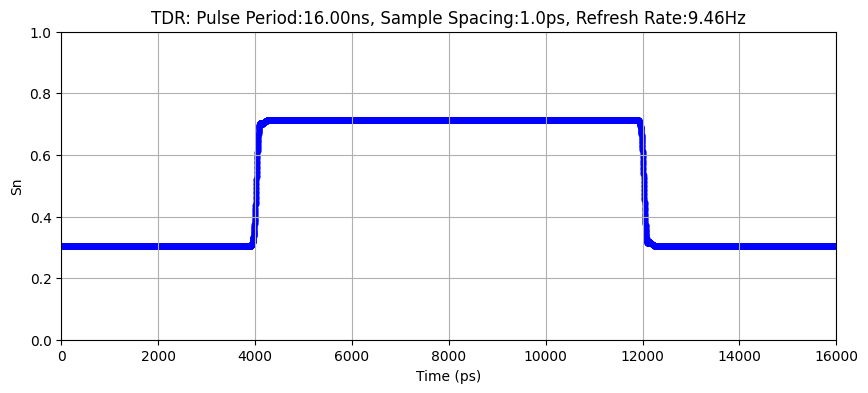

In [7]:
def radium_state_updates(radium_stub: RadiumStub, logger: logging.Logger, radium_state_event_listener_it: Iterator[radium_public_pb2.StateEvent]):
    '''Get radium state updates in a separate thread.'''
    try:
        while True:
            state = radium_stub.GetState(radium_public_pb2.GetStateRequest())
            if state.acquisition_stalled: logger.error(f"Acquisition stalled")
            next(radium_state_event_listener_it)
    except grpc.RpcError as e:
        if running_evt.is_set(): logger.error(f"gRPC error: {e.code()} - {e.details()}")


def radium_sample_stream(radium_stub: RadiumStub, logger: logging.Logger, sample_stream_queue: queue.Queue, sample_stream_listener_it: Iterator[radium_public_pb2.SampleStream]):
    '''Stream samples in a separate thread.'''
    try:
        rx_count = 0
        prev_log_rx_stream_rate_time = time.time()
        while True:
            next_msg = next(sample_stream_listener_it)
            rx_count += 1
            now = time.time()
            log_rx_stream_rate_interval_sec = 5
            if (now - prev_log_rx_stream_rate_time) > log_rx_stream_rate_interval_sec:
                rate = rx_count / (now - prev_log_rx_stream_rate_time)
                #logger.info(f"RX sample stream rate is:{rate:.2f}Hz")
                if rx_count != 0:
                    prev_log_rx_stream_rate_time = now
                    rx_count = 0
            try: sample_stream_queue.put(next_msg, block=False)
            except queue.Full: pass
    except grpc.RpcError as e:
        if running_evt.is_set(): logger.error(f"gRPC error: {e.code()} - {e.details()}")


# Entry.
running_evt = threading.Event()
running_evt.set()
radium_stub = RadiumStub(grpc.insecure_channel(host_addr + ":50052"))
try:
    radium_stub.IsReady(radium_public_pb2.IsReadyRequest(), timeout=5)
except Exception as e:
    logging.error(e)
    sys.exit()
radium_state = radium_stub.GetState(radium_public_pb2.GetStateRequest())
if not radium_state.HasField("pulse_period_ns") or not radium_state.HasField("sample_spacing_ps"):
    radium_stub.ConfigureTDRPreset(radium_public_pb2.ConfigureTDRPresetRequest(preset=radium_public_pb2.TDR_CONFIGURATION_PRESET_PULSE_PERIOD_16P0_NS_SAMPLE_SPACING_100P0_PS))
radium_stub.EnableTDR(radium_public_pb2.EnableTDRRequest(enable=True))
sample_stream_queue = queue.Queue(maxsize=10)
radium_state_event_listener_it = radium_stub.ListenToStateEvent(radium_public_pb2.ListenToStateEventRequest())
sample_stream_listener_it = radium_stub.ListenToSampleStream(radium_public_pb2.ListenToSampleStreamRequest())
radium_state_work_thread = threading.Thread(target=radium_state_updates, args=(radium_stub, logger, radium_state_event_listener_it))
radium_state_work_thread.start()
sample_stream_work_thread = threading.Thread(target=radium_sample_stream, args=(radium_stub, logger, sample_stream_queue, sample_stream_listener_it))
sample_stream_work_thread.start()

# Visualization - initialization.
plt.figure(figsize=(10, 4))
plt.title("Waiting for stream...")
plt.xlabel('Time (ps)')
plt.ylabel('Sn')
plt.ylim(0, 1)
plt.xlim(0, 1)
title = ""
sample_stream_count = 0
prev_update_plot_title_time = time.time()
pulse_period_ns = None
sample_spacing_ps = None
prev_displayed_pulse_period_ns = None
prev_displayed_sample_spacing_ps = None

# Visualization - loop for the given run time.
run_time_sec = 10
start_time = time.time()
while (time.time() - start_time) < run_time_sec:
    # Poll the queue for a new sample_stream.
    try:
        # Get a new sample stream and compute the pulse period.
        sample_stream = sample_stream_queue.get(timeout=0.001)
        sample_stream_count += 1
        sample_spacing_ps = sample_stream.sample_spacing_ps
        pulse_period_ns = sample_stream.pulse_period_ns

        # Draw.
        x = np.arange(len(sample_stream.sample)) * sample_spacing_ps
        y = sample_stream.sample
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        plt.scatter(x, y, c='blue', s=10)
        plt.title(title)
        plt.xlabel('Time (ps)')
        plt.ylabel('Sn')
        plt.ylim(0, 1)
        xlim_max = len(sample_stream.sample) * sample_spacing_ps
        plt.xlim(0, xlim_max)
        plt.grid(True)
        plt.show()

    except queue.Empty:
        pass

    # Update title.
    # Restart the counter and the previous refresh rate timestamp only if we have something. Otherwise, refresh the display of slow refresh rates will reset to 0 between updates.
    if (sample_spacing_ps is not None):
        now = time.time()
        title_update_interval_without_state_change_sec = 1
        if ((now - prev_update_plot_title_time) > title_update_interval_without_state_change_sec) or sample_spacing_ps != prev_displayed_sample_spacing_ps or pulse_period_ns != prev_displayed_pulse_period_ns:
            rate = sample_stream_count / (now - prev_update_plot_title_time)
            title = f"TDR: Pulse Period:{pulse_period_ns:.2f}ns, Sample Spacing:{sample_spacing_ps}ps, Refresh Rate:{'--' if prev_displayed_sample_spacing_ps is None else f'{rate:.2f}'}Hz"
            if sample_stream_count != 0:
                sample_stream_count = 0
                prev_update_plot_title_time = now

    # Pause to allow matplotlib event loop to run such that the UI will stay responsive.
    plt.pause(0.001)

    # Update previous state.
    prev_displayed_sample_spacing_ps = sample_spacing_ps
    prev_displayed_pulse_period_ns = pulse_period_ns

# Clean up.
running_evt.clear()
radium_state_event_listener_it.cancel()
sample_stream_listener_it.cancel()
radium_state_work_thread.join()
sample_stream_work_thread.join()